S 1
3


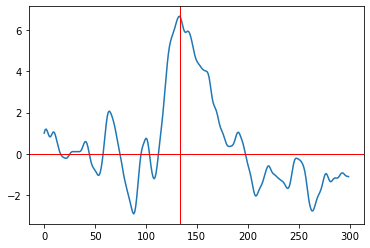

S 2
3


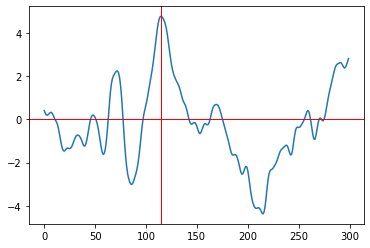

S 3
3


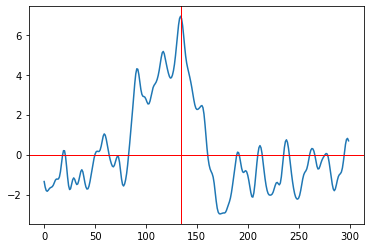

S 4
3


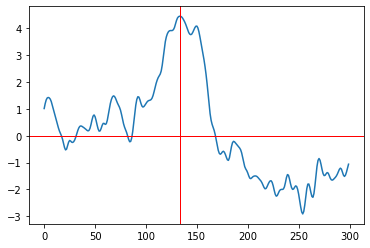

S 5
3


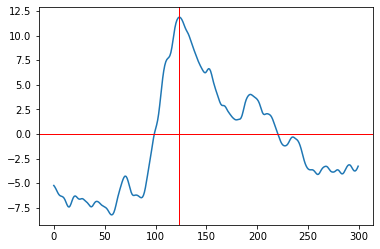

S 6
3


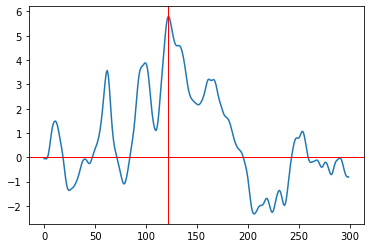

S 8
3


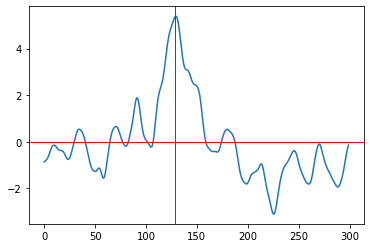

S 10
3


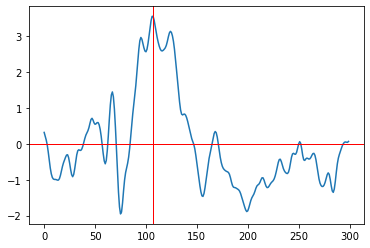

S 11
3


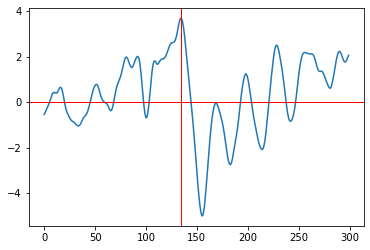

S 12
3


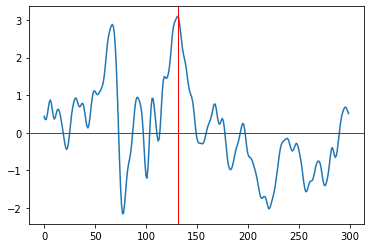

S 14
3


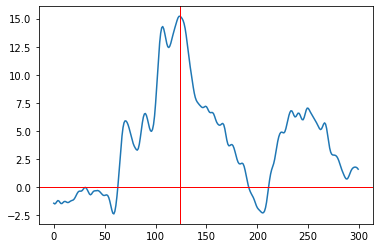

S 15
3


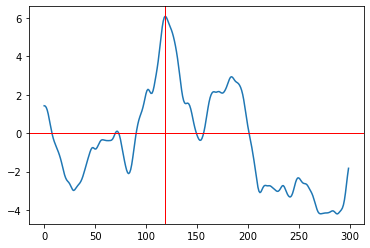

S 16
3


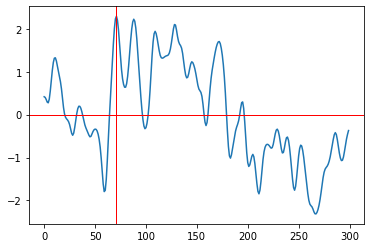

S 17
3


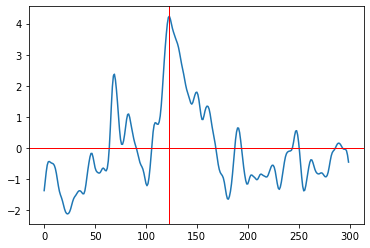

S 18
3


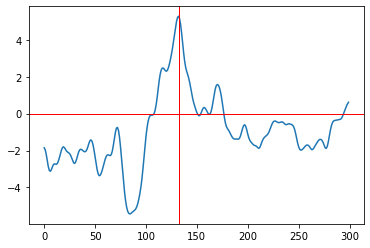

S 19
3


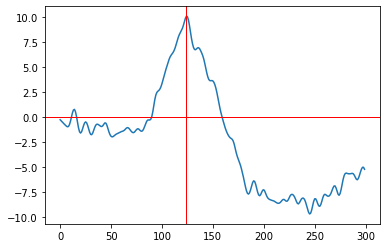

S 20
3


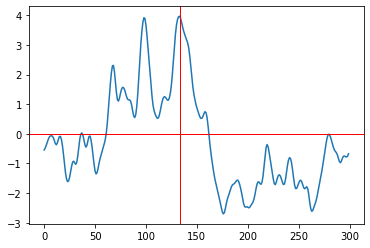

[133. 115. 134. 133. 123. 122. 129. 107. 134. 131. 124. 119.  71. 123.
 132. 124. 133.]
14.882004180986733


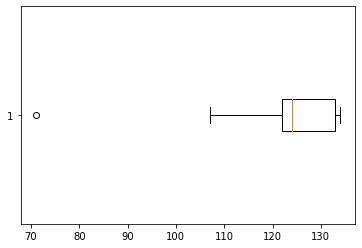

[ 6.67  4.77  6.92  4.45 11.86  5.8   5.39  3.56  3.69  3.1  15.21  6.08
  2.29  4.24  5.28 10.12  3.97]
3.2798612663718663


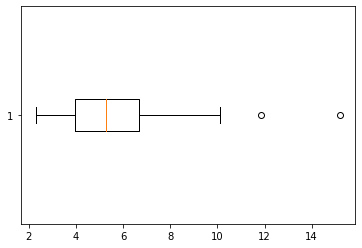

In [1]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
%matplotlib inline
import math
def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)

        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq)) 
        baseline = int(np.floor(1 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_d(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_d(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        #EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        #EpochsT = Standardization(EpochsT)
        #EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        max_I=0
        max_V=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()          
        return [EpochsT[:,:,:], EpochsN[:,:,:],max_I,max_V]

def normal_pdf(x, mu=0, sigma=1):
    return(math.exp(-(x-mu)**2)/(2*sigma**2))/(math.sqrt(2*math.pi)*sigma)

def main():
    hz=180   
   
    root = 'D:\\VR300_20\\S'
    T_all_V= np.zeros((17*210,7,300))
    N_all_V= np.zeros((17*1260,7,300))
    count = 0
    Max_P=np.zeros(17)
    Max_V=np.zeros(17)
    for i in np.arange(1,21):
        if(i==7 or i==9 or i==13):
            continue
        if(i<10):
            count = count + 1
            root_VR = root + '0' + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        else:
            count = count + 1
            root_VR = root + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        print("S",i)
        [T_all_V[210*(count-1):210*count,:,:],N_all_V[1260*(count-1):1260*count,:,:],Max_P[count-1],Max_V[count-1]]=plotGraph_v(root_VR)
        #-------------------------------------------------------    
    print(Max_P)
    print(np.std(Max_P))
    plt.boxplot(Max_P, vert=False)
    plt.show()  
    print(np.round(Max_V,2))
    print(np.std(Max_V))
    plt.boxplot(Max_V, vert=False)
    plt.show()  

if __name__ == "__main__":
    main()

1
3


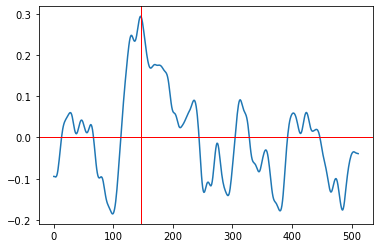

2
3


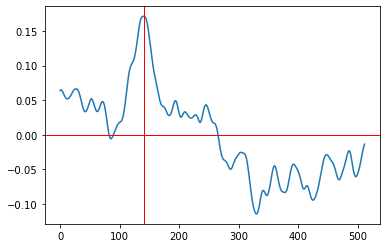

3
3


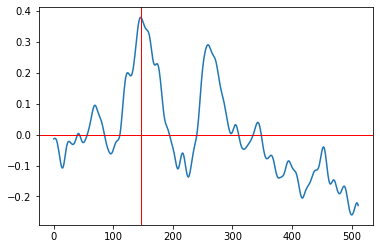

4
3


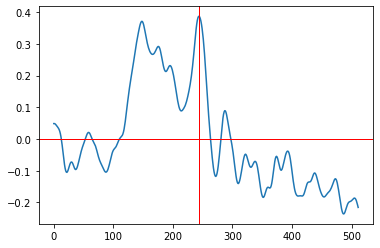

7
3


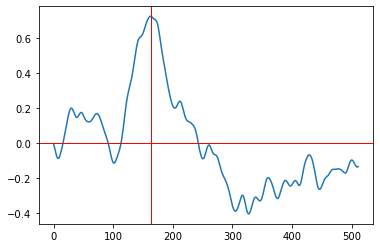

8
3


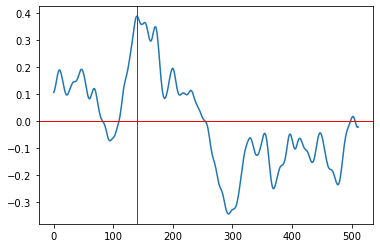

9
3


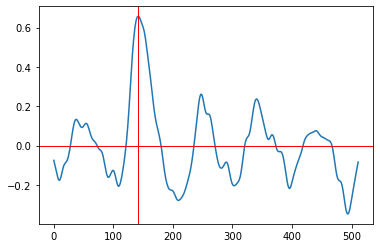

10
3


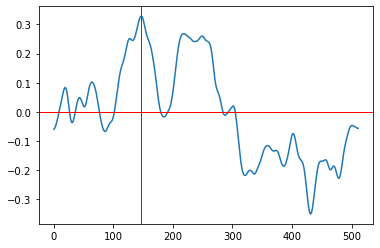

11
3


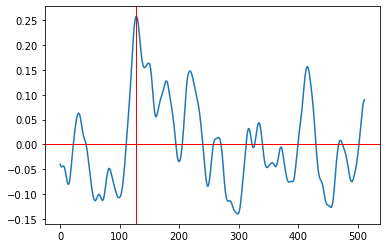

12
3


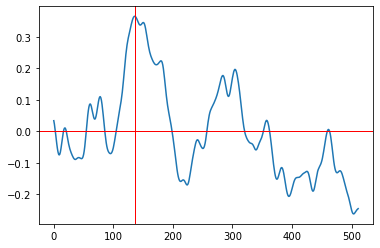

13
3


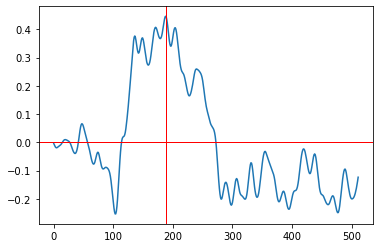

14
3


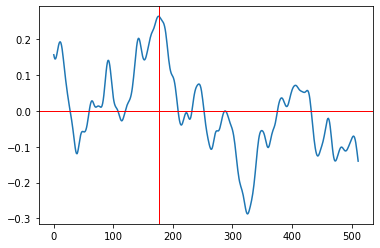

15
3


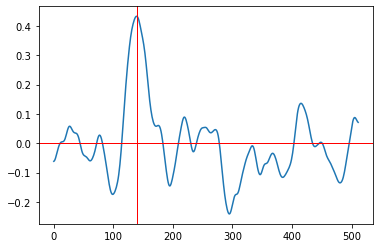

16
3


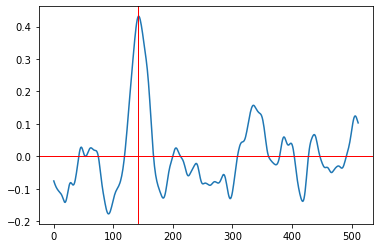

17
3


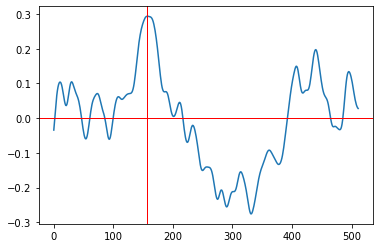

18
3


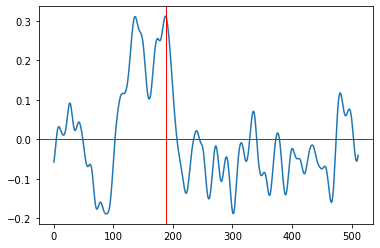

19
3


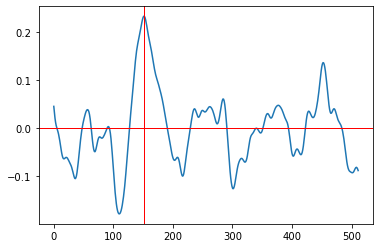

20
3


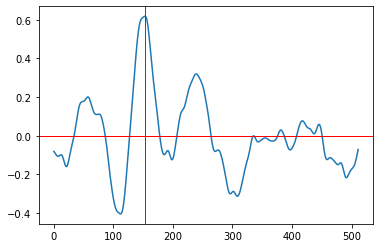

21
3


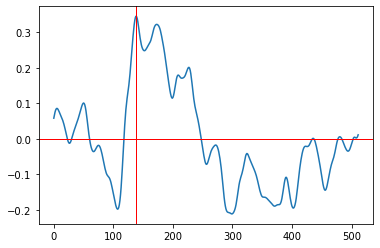

22
3


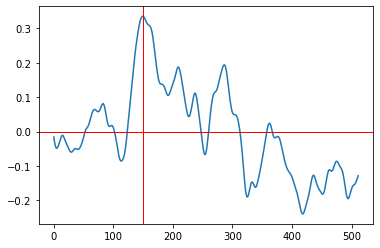

23
3


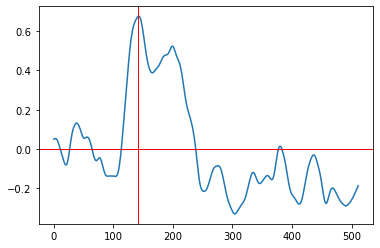

24
3


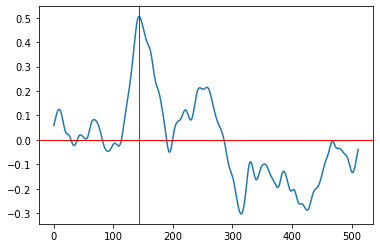

26
3


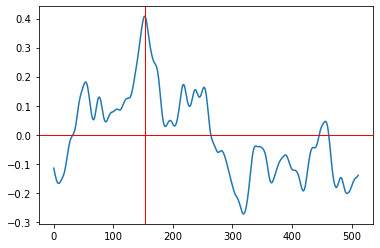

27
3


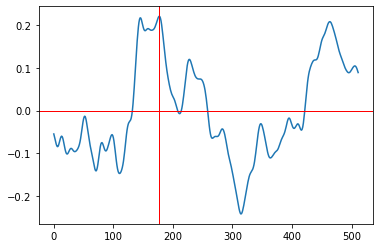

28
3


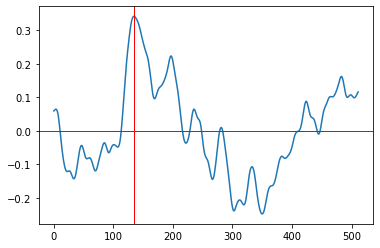

29
3


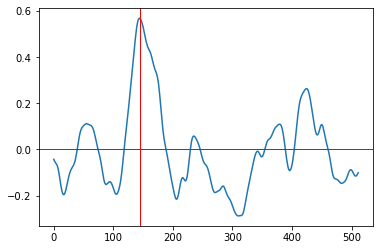

30
3


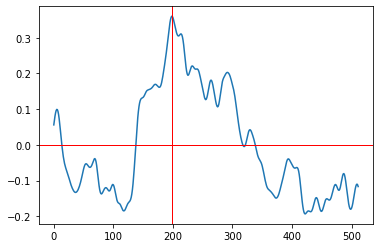

31
3


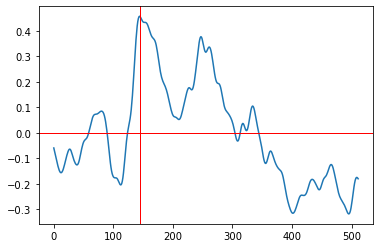

32
3


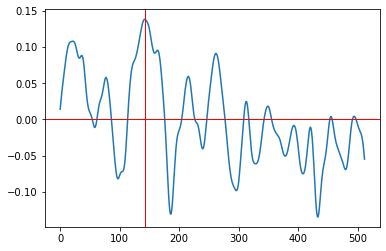

33
3


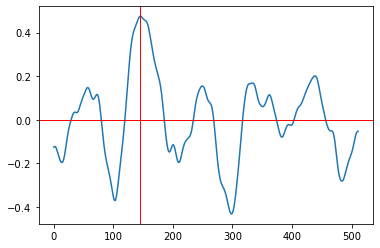

34
3


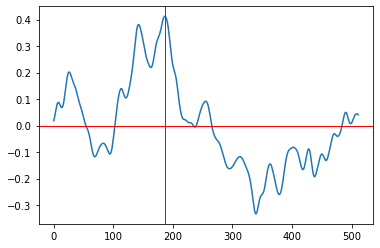

35
3


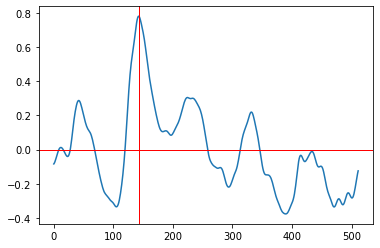

36
3


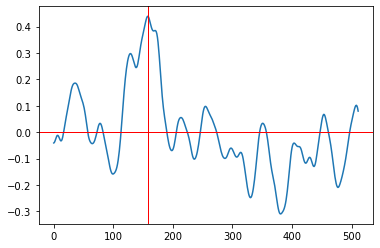

37
3


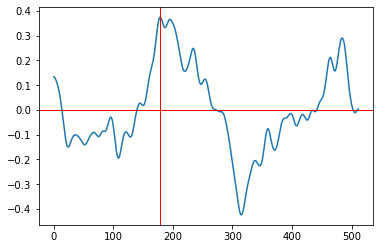

39
3


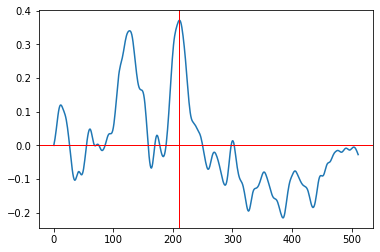

40
3


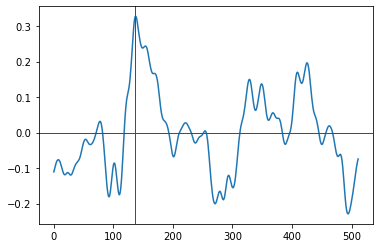

41
3


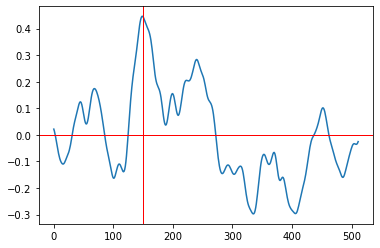

42
3


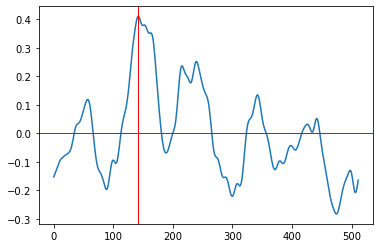

43
3


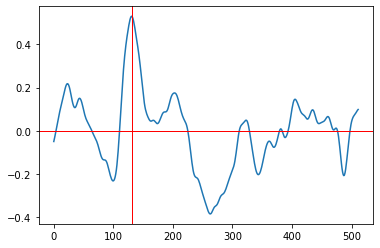

46
3


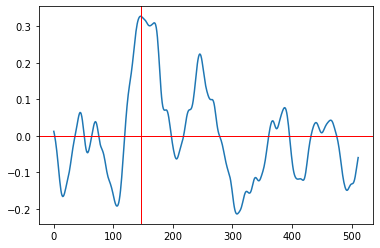

47
3


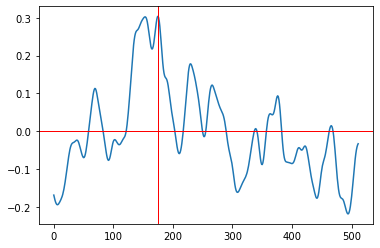

48
3


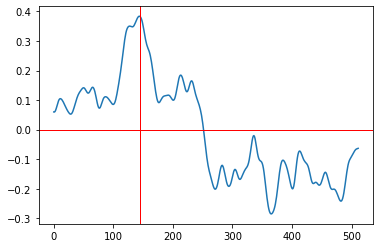

49
3


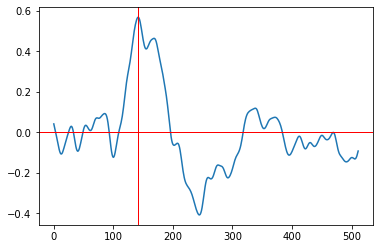

50
3


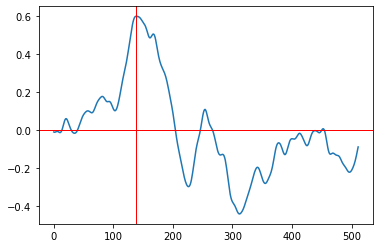

51
3


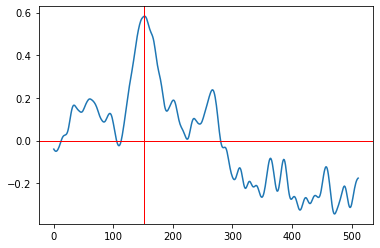

54
3


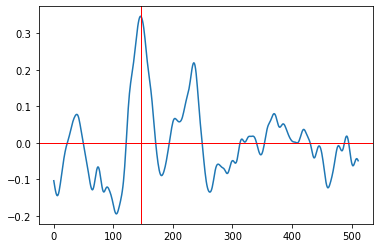

[146. 140. 146. 244. 163. 140. 142. 147. 128. 136. 188. 176. 139. 142.
 157. 188. 151. 153. 138. 149. 142. 143. 153. 177. 135. 144. 198. 144.
 142. 145. 186. 143. 158. 179. 211. 137. 149. 142. 131. 146. 175. 144.
 142. 138. 152. 146.]
22.81785565871613


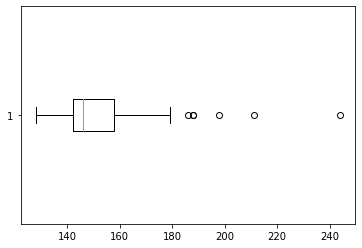

[0.29 0.17 0.38 0.39 0.72 0.39 0.66 0.33 0.26 0.37 0.45 0.26 0.43 0.43
 0.29 0.31 0.23 0.62 0.35 0.34 0.68 0.51 0.41 0.22 0.34 0.57 0.36 0.46
 0.14 0.47 0.41 0.78 0.44 0.37 0.37 0.33 0.45 0.41 0.53 0.33 0.3  0.38
 0.57 0.6  0.58 0.35]
0.13994344600800682


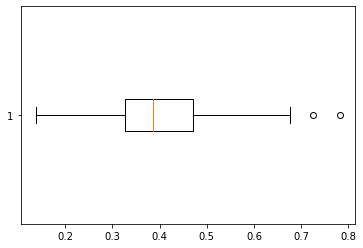

In [50]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

    
def plotGraph_b(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 150
        resampleRate = 300
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))


        mat = hdf5storage.loadmat(filename)
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq'][0,0]
        stimsN = mat['stimsN']
        stimsT = mat['stimsT']
        sampleNum = eegData.shape[1]
        channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
        eegData = eegData[channelIndex]
            
            ## Preprocessing process
        eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, 4)
        
#             #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq))
        baseline = int(np.floor(1 * samplingFreq))
        [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        NumN = NumT
        EpochsN = Balancing_DataSet(EpochsN, NumN)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, 0)
        EpochsT_Aver = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN_Aver = resampling(EpochsN, NumN, resampleRate, channelNum)
        Target_All=np.mean(EpochsT,axis=0)
        max_I=0
        max_V=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        
        return [EpochsT_Aver, EpochsN_Aver,max_I,max_V]
def main():
    hz=180
    filename = ''
    channelNum = 7 # (n_components)
    epochSampleNum = 300
    epochNum = 150
    epochNum_N = 150
    subject_num = []
    root = 'D:\\P300_biosemi_55\\S'
    T_all = np.zeros((epochNum*49,channelNum,hz))
    N_all = np.zeros((epochNum_N*49,channelNum,hz))
    count =0
    Max_P=np.zeros(46)
    Max_V=np.zeros(46)    
    co = np.zeros((46,7))
    
    for l in np.arange(1,56):
        if(l==25 or l==44 or l==53 or l==6 or l==38 or l==52 or l==5 or l==45 or l==55): 
            continue
        if(l<10):
            count = count + 1
            filename = root + '0' + str(l)
        else:
            count = count +1
            filename = root + str(l)
        T_all_b= np.zeros((epochNum,7,epochSampleNum))
        N_all_b= np.zeros((epochNum_N,7,epochSampleNum))
        print(l)
        [T_all_b[:,:,:],N_all_b[:,:,:],Max_P[count-1],Max_V[count-1]]=plotGraph_b(filename)
    print(Max_P)
    print(np.std(Max_P))
    plt.boxplot(Max_P, vert=False)
    plt.show()  
    print(np.round(Max_V,2))
    print(np.std(Max_V))
    plt.boxplot(Max_V, vert=False)
    plt.show()
    
    
    
if __name__ == "__main__":
    main()

(210, 7, 300)
(7, 300)
[ 29. 233.  86.  76.  37. 270.  90. 280. 160. 211.   1.  90.  15. 180.
 122. 126. 276. 124. 181. 295. 299. 132. 173.   1. 156. 134. 125. 128.
  18. 136. 297. 264. 102. 228.  23.  87. 111. 208. 268.   4. 135.   0.
 122. 268. 137. 175. 224. 167.  97. 207.  15.  27. 111. 252.  69.   3.
  26. 234. 272. 128.  19. 131.  21.  94. 214. 126.  14. 248.   6. 162.
  97.  32.  44. 290. 244. 131.   8. 120. 134.  63. 111. 299. 253. 263.
 159. 126.  92.   3.  31.  58. 110. 241. 180.  34. 276. 127.  34. 295.
  43. 233. 159. 261.  27. 177. 169. 222.  94. 299. 187.  70. 244. 146.
  55. 181.   6. 187. 125. 286.   0. 157. 279. 266. 286. 152.   0. 135.
 235. 117.  55. 175. 191. 170. 117.  99.  35.  28.  11.  66. 212.   7.
 267. 255.  20. 295. 122. 129. 111.  90. 243.  92.   2. 122. 245. 135.
 103. 130.  33. 112. 131. 297. 140.  79. 231. 213.  91. 129. 270. 150.
 269. 146. 202. 183.  20.  40. 203. 100.   5.  16. 184. 111. 150.  41.
  51. 200. 299.  49.  72. 296. 156. 118. 175.  61.   0

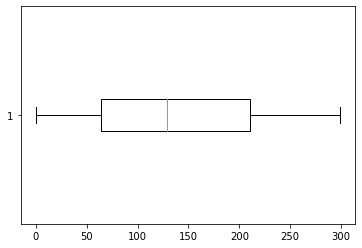

[39.21  5.82 20.91 13.5  32.97 10.12 12.22 17.91 10.18 18.81 16.11 14.44
 16.27  9.53  8.76 16.77 13.22 27.42 18.75 16.69 17.39 24.84 10.5  21.13
  9.48 21.92 11.1  15.74 22.35 17.22 14.35 22.49 38.42 -0.32 36.04 22.25
 29.2  21.87 28.91 13.27 27.4  17.13 37.6   5.8  21.37 24.46 15.62 15.62
 21.84 16.33 13.35 10.77 17.03 19.79 22.78 14.24 22.97 16.68 16.45 24.99
 -2.75 55.65 40.72 11.14 21.34 24.2  24.2  16.09 14.94 21.14 17.43  9.11
 23.87 14.34 17.53 12.56 12.56 23.13 17.25 14.29 14.69 19.63  9.59 23.96
 11.04 13.87 16.02 21.69 13.14 21.32 57.65 -1.41 53.48 15.61 28.9  45.26
 32.88  8.18 23.81 44.22 22.24 39.11 31.66 31.22 31.35 12.22 15.26 14.14
 33.96 17.54 17.82 23.85  5.98 35.78 35.78 26.41 11.84 13.89 16.62 29.87
 56.39 64.16  9.05 15.25 12.73 26.78 13.15 15.71 15.71 30.4  14.59 30.56
 14.2  13.56 17.83 20.14 16.47 15.78 16.53 22.13 10.64 24.7  24.7  18.37
 24.91 23.39 24.17 15.39 18.94 21.41 14.7  14.32 25.8  28.87 16.68 14.67
 18.19 23.74  9.27 12.13  4.86 11.02 14.51 19.23 14

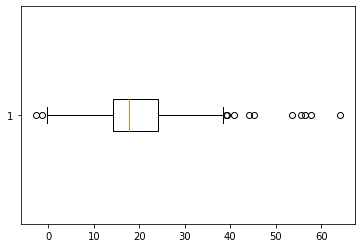

In [67]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
%matplotlib inline
import math
def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)

        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq)) 
        baseline = int(np.floor(1 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_d(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_d(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        #EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        #EpochsT = Standardization(EpochsT)
        #EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        print(EpochsT.shape)
        print(Target_All.shape)

        max_I=np.zeros(210)
        max_V=np.zeros(210)
        for k in np.arange(0,210):
            a=k+1
            #plt.plot(EpochsT[k,2,:])
            #plt.axvline(x=np.argmax(EpochsT[k,2,:]), color='r', linewidth=1)
            max_I[k]=np.argmax(EpochsT[k,2,:])
            max_V[k]=max(EpochsT[k,2,:])
            #plt.axhline(y=0, color='r', linewidth=1)
            #plt.show()          
        return [max_I,max_V]


def main():
    hz=180   
   
    root = 'D:\\VR300_20\\S08\\Training\\mat\\'
    count = 1
    Max_P=np.zeros(210)
    Max_V=np.zeros(210)
    current_list = sorted(glob.glob(root + '*.mat'), key=os.path.getmtime, reverse=True)
    root_VR = current_list[0]
    [Max_P,Max_V]=plotGraph_v(root_VR)

    print(Max_P)
    print(np.std(Max_P))
    plt.boxplot(Max_P, vert=False)
    plt.show()  
    print(np.round(Max_V,2))
    print(np.std(Max_V))
    plt.boxplot(Max_V, vert=False)
    plt.show()  

if __name__ == "__main__":
    main()

(150, 7, 512)
[ 37.   2. 147.  72. 379. 187.  13. 511. 454. 166. 432. 336.  24. 489.
   9. 407. 164. 152. 475. 187. 509. 413. 180. 352. 187. 317.  18.  26.
 334. 142. 299. 203. 425. 137. 150.  54. 205.  39. 165.  22. 344. 248.
 173. 129. 409. 313. 208.  16. 477. 485. 287. 420. 399. 446. 219. 272.
 300. 166.  12. 299. 280. 471. 445. 281. 241. 454. 166. 453. 131. 503.
  13. 478. 314. 288. 443. 367.  13. 498. 338.  50.  88. 423. 176.  80.
  66. 262. 412. 124. 371. 179. 172.   4.  65.  35. 139. 352.  10. 325.
 351. 159. 238. 115. 411. 123. 407. 326.  45.  23. 504.  42. 378. 511.
  79. 362. 167. 406. 485.  78. 293. 428. 318. 396.  23. 111. 195. 157.
 400. 136. 236. 142. 118. 189. 286. 362. 126. 423. 445. 135. 273. 300.
 368. 112. 438. 338. 465. 369. 511. 223. 236. 140.]
154.29125185829557


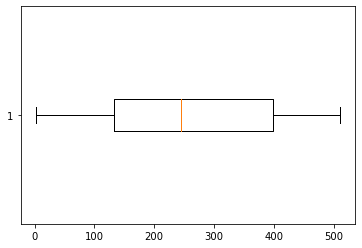

[2.79 1.85 2.54 0.23 2.36 2.36 2.56 1.16 2.21 2.21 1.79 1.79 1.29 1.85
 1.85 2.21 3.72 1.37 1.61 1.61 1.96 1.96 2.42 1.14 2.17 1.99 2.56 1.23
 1.18 1.18 1.57 1.57 2.06 2.06 3.3  3.3  1.97 2.25 1.69 1.07 3.25 3.25
 2.52 1.9  2.83 2.83 1.71 1.71 1.54 2.27 1.11 1.68 2.11 2.37 2.05 2.18
 2.25 1.92 1.71 1.06 1.75 2.94 1.88 2.   1.64 1.79 1.79 1.64 3.02 2.06
 1.32 2.53 1.68 1.61 1.97 2.6  1.2  2.33 2.29 2.29 0.82 2.11 1.22 1.22
 1.44 1.33 2.74 2.74 1.3  1.3  1.26 2.27 2.64 2.77 1.06 1.93 1.1  0.91
 1.87 1.87 1.85 1.05 1.89 1.89 1.78 2.32 2.89 1.37 1.62 2.58 1.77 2.67
 1.33 1.99 2.36 1.72 2.48 2.   0.5  0.95 1.43 1.91 0.77 2.61 1.93 3.01
 0.97 2.89 2.44 0.81 2.66 2.12 1.46 2.83 2.77 2.44 2.15 2.41 2.22 2.66
 2.42 1.5  1.71 2.07 2.24 2.24 1.75 1.75 2.65 2.65]
0.6232530729414099


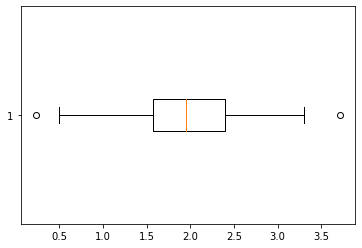

In [70]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

    
def plotGraph_b(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 150
        resampleRate = 300
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))


        mat = hdf5storage.loadmat(filename)
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq'][0,0]
        stimsN = mat['stimsN']
        stimsT = mat['stimsT']
        sampleNum = eegData.shape[1]
        channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
        eegData = eegData[channelIndex]
            
            ## Preprocessing process
        eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, 4)
        
#             #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq))
        baseline = int(np.floor(1 * samplingFreq))
        [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        NumN = NumT
        EpochsN = Balancing_DataSet(EpochsN, NumN)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        #[EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, 0)
        EpochsT_Aver = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN_Aver = resampling(EpochsN, NumN, resampleRate, channelNum)
        print(EpochsT.shape)
        
        Target_All=np.mean(EpochsT,axis=0)

        max_I=np.zeros(150)
        max_V=np.zeros(150)
        for k in np.arange(0,150):
            a=k+1
            #plt.plot(EpochsT[k,2,:])
            #plt.axvline(x=np.argmax(EpochsT[k,2,:]), color='r', linewidth=1)
            max_I[k]=np.argmax(EpochsT[k,2,:])
            max_V[k]=max(EpochsT[k,2,:])
            #plt.axhline(y=0, color='r', linewidth=1)
            #plt.show()          
        return [max_I,max_V]
def main():
    hz=180
    filename = ''
    channelNum = 7 # (n_components)
    epochSampleNum = 300
    epochNum = 150
    epochNum_N = 150
    subject_num = []
    root = 'D:\\P300_biosemi_55\\S01'
    T_all = np.zeros((epochNum*49,channelNum,hz))
    N_all = np.zeros((epochNum_N*49,channelNum,hz))
    count =1
    Max_P=np.zeros(150)
    Max_V=np.zeros(150)    
    [Max_P,Max_V]=plotGraph_b(root)

    print(Max_P)
    print(np.std(Max_P))
    plt.boxplot(Max_P, vert=False)
    plt.show()  
    print(np.round(Max_V,2))
    print(np.std(Max_V))
    plt.boxplot(Max_V, vert=False)
    plt.show()
    
    
    
if __name__ == "__main__":
    main()

1


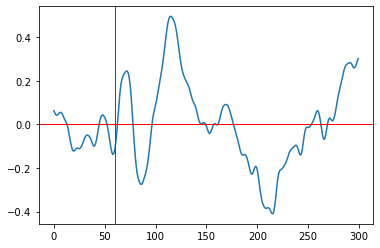

2


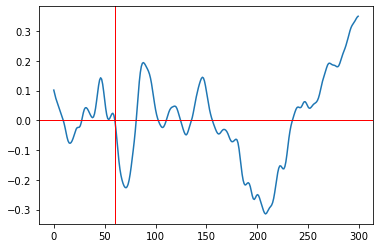

3


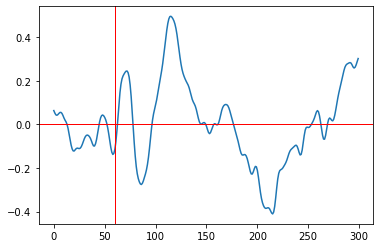

4


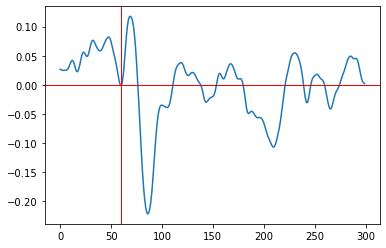

5


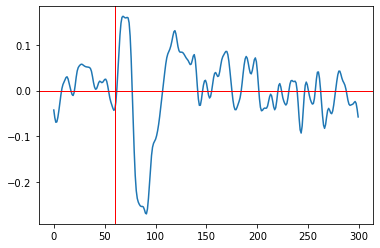

6


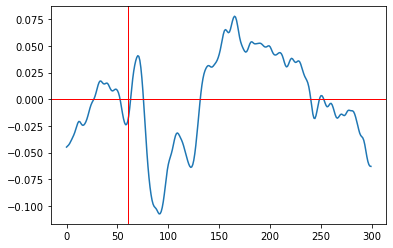

7


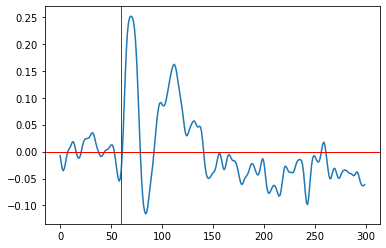

(210, 7, 300)
(210, 7, 300)


In [11]:
## train의 test값을 저장 한다. 
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
        
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs

def plotGraph(filename):

        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)

        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0* samplingFreq)) 
        baseline = int(np.floor(1 * samplingFreq)) 
        [EpochsT, NumT] = Epoching(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        for k in np.arange(0,7):
            a=k+1
            print(a)
            plt.plot(Target_All[k,:])
            plt.axvline(x=60, color='r', linewidth=1)
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()          
        return [EpochsT[:,:,:], EpochsN[:,:,:]]


def main():
    #root = 'D:\\VR300Data\\0129\\Eunjin\\Training\\mat\\Training.mat'
    root =  'D:\\VR300_20\\S02\\Training\\mat\\Training.mat'
    T_all= np.zeros((210,7,300))
    N_all= np.zeros((210,7,300))

    [T_all[:,:,:],N_all[:,:,:]]=plotGraph(root)
    mat_file = io.loadmat(root)
    
    target_data = T_all
    non_target_data = N_all

    print(target_data.shape)
    print(non_target_data.shape)
#-----------------------------------------
    output_file = "./resampled_data_test.npz"
    np.savez(output_file, np.array(target_data,dtype=float), np.array(non_target_data,dtype=float))
#-------------------------------------

    
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model


# filtering bandwidth
low, high = 0.1, 30

resampleRate = 100
def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
#         Classifier_path = 'C:\\Users\\user\\Desktop\\Model\\'
#         classifier_list = sorted(glob.glob(Classifier_path + '*.pickle'), key=os.path.getmtime, reverse=True)
#         print("classifer:", classifier_list[0])

#         lda = joblib.load(classifier_list[0])
        
        
        classifier = "D:\\VR300Data\\0129\\Minchul\\0130_1720Classifier.pickle"        
        lda = joblib.load(classifier)
        print(classifier)
        root_path = "D:\\VR300Data\\0129\\Minchul\\"

        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(1.0 * samplingFreq))
            offset = int(np.floor(0.0 * samplingFreq))
            baseline = int(np.floor(1.0 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            
            
            #answer=model(Epochs_final)
            #print(buttonNum)
            #print(featureNum)
            
            Features = Convert_to_FeatureVector(Epochs_final, buttonNum, featureNum)
            Answers = lda.decision_function(Features)
            output_file = "./resampled_VR300_1_5.npz"
            np.savez(output_file,  Epochs_Aver)
            #Answers= model(Features)
            for i in range(buttonNum):
                if i == int(ans)-1:
                    target_val = target_val + Answers[i]
                else:
                    nontarget_val = nontarget_val + Answers[i]
            
            answer = np.argmax(Answers) + 1
            
            print(Answers)
            if int(ans) == int(answer): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', answer)
        
        print('wrong answer', wrong_ans)
        print('score:', score, '/', len(current_list))

        print('target mean:', target_val / len(current_list))
        print('nontarget mean:', nontarget_val / (len(current_list)*6))
    
if __name__ == "__main__":
    main()

In [18]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Epoching_b(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch
def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs

def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    EpochsT = Standardization(EpochsT)
    EpochsN = Standardization(EpochsN)
    
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]    

def plotGraph_v(filename):

        Classifier_path = 'D://P300_biosemi_55//Model//LDA// '+ 'lda.pickle'
        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
 #Convert to feature vector
        [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver] = Make_Average_Component(EpochsT, NumT, EpochsN_New, NumT, channelNum, epochSampleNum, 20)

        featureNum = channelNum*epochSampleNum
        print(EpochsT_Aver.shape)
        print(EpochsN_Aver.shape)
        print(featureNum)
        [FeaturesT, FeaturesN] = Convert_to_featureVector(EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver, featureNum)
        TrainData = np.concatenate((FeaturesT, FeaturesN))
        TrainLabel = np.concatenate((np.ones((NumT_Aver,1)).astype(int),np.zeros((NumN_Aver,1)).astype(int))).ravel()
        
        #Saving LDA classifier
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda.fit(TrainData, TrainLabel)
        joblib.dump(lda, Classifier_path, protocol=2)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]    
    

def main():
    
    root_VR =  'D:\\VR300_20\\S08\\Training\\mat\\Training.mat'
    T_all_V= np.zeros((210,7,180))
    N_all_V= np.zeros((210,7,180))
    [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
    Target_All=np.mean(T_all_V,axis=0)


    
if __name__ == "__main__":
    main()

(190, 7, 180)
(190, 7, 180)
1260


In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        print(max_I)
        root_path = "D:\\VR300Data\\0315\\Minchul\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            #max_I np.mean(T_all_V,axis=0)
    #*********************************************************
            hz=180

            target_data = Epochs_Aver[int(ans)-1,:,:]
            print(int(ans)-1)
            mat = np.zeros((2, hz))
     
            plt.plot(np.mean(Epochs_Aver[int(ans)-1,:,:],axis=0))
            plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
            max_I=np.argmax(Target_All[k,:])
            max_V =max(Target_All[k,:])
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()
            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(80)
                q=0
                for b in np.arange(0,80):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
    #*********************************************************             
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()